In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
# Define image size and batch size
img_height, img_width = 224, 224
batch_size = 32

# Paths to the directories
train_dir = r'C:\Users\Admin\Desktop\Python files\ML Projects\Guava Disease\GuavaDiseaseDataset\GuavaDiseaseDataset\train'
val_dir = r'C:\Users\Admin\Desktop\Python files\ML Projects\Guava Disease\GuavaDiseaseDataset\GuavaDiseaseDataset\val'
test_dir = r'C:\Users\Admin\Desktop\Python files\ML Projects\Guava Disease\GuavaDiseaseDataset\GuavaDiseaseDataset\test'

# Data Augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,                # Normalize pixel values to [0, 1]
    rotation_range=20,             # Mild rotations
    width_shift_range=0.1,         # Mild horizontal shifts
    height_shift_range=0.1,        # Mild vertical shifts
    shear_range=0.1,               # Mild shear transformations
    zoom_range=0.1,                # Mild zoom
    horizontal_flip=True,          # Random horizontal flip
    brightness_range=[0.9, 1.1],   # Adjust brightness slightly
    fill_mode='nearest'            # Fill missing pixels after transformations
)

# Similar preprocessing for validation and test data with minimal augmentations
val_test_datagen = ImageDataGenerator(
    rescale=1./255
)

In [3]:
# Creating data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'  # Assuming multi-class classification
)

validation_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Important for evaluation
)

Found 2647 images belonging to 3 classes.
Found 755 images belonging to 3 classes.
Found 382 images belonging to 3 classes.


In [7]:
# Learning Rate Scheduler and Early Stopping
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [9]:
# Load a pretrained model (MobileNetV2) and fine-tune
base_model = tf.keras.applications.MobileNetV2(
    weights='imagenet', 
    include_top=False, 
    input_shape=(img_height, img_width, 3)
)
base_model.trainable = False  # Freeze the pretrained layers

In [11]:
# Building the transfer learning model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')  # Number of output classes
])
# Model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,339 (9.24 MB)

 Trainable params: 164,355 (642.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [13]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-3),  # Larger learning rate for initial fine-tuning
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [15]:
# Train the model with callbacks
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[lr_scheduler, early_stopping]
)

C:\Users\Admin\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 300s 4s/step - accuracy: 0.7657 - loss: 2.4840 - val_accuracy: 0.9674 - val_loss: 1.0737 - learning_rate: 0.0010
Epoch 2/20
 1/82 ━━━━━━━━━━━━━━━━━━━━ 1:05 810ms/step - accuracy: 0.9375 - loss: 1.1205

C:\Users\Admin\anaconda3\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


82/82 ━━━━━━━━━━━━━━━━━━━━ 19s 223ms/step - accuracy: 0.9375 - loss: 1.1205 - val_accuracy: 0.9688 - val_loss: 1.0668 - learning_rate: 0.0010
Epoch 3/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 188s 2s/step - accuracy: 0.9422 - loss: 1.0025 - val_accuracy: 0.9742 - val_loss: 0.6108 - learning_rate: 0.0010
Epoch 4/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 19s 227ms/step - accuracy: 0.9062 - loss: 0.6863 - val_accuracy: 0.9769 - val_loss: 0.6080 - learning_rate: 0.0010
Epoch 5/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 190s 2s/step - accuracy: 0.9619 - loss: 0.5861 - val_accuracy: 0.9742 - val_loss: 0.4190 - learning_rate: 0.0010
Epoch 6/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 21s 256ms/step - accuracy: 0.9062 - loss: 0.5016 - val_accuracy: 0.9769 - val_loss: 0.4101 - learning_rate: 0.0010
Epoch 7/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 244s 3s/step - accuracy: 0.9600 - loss: 0.4299 - val_accuracy: 0.9742 - val_loss: 0.3135 - learning_rate: 0.0010
Epoch 8/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 17s 203ms/step - accuracy: 0.9688 - loss: 0.3524 - val_accura

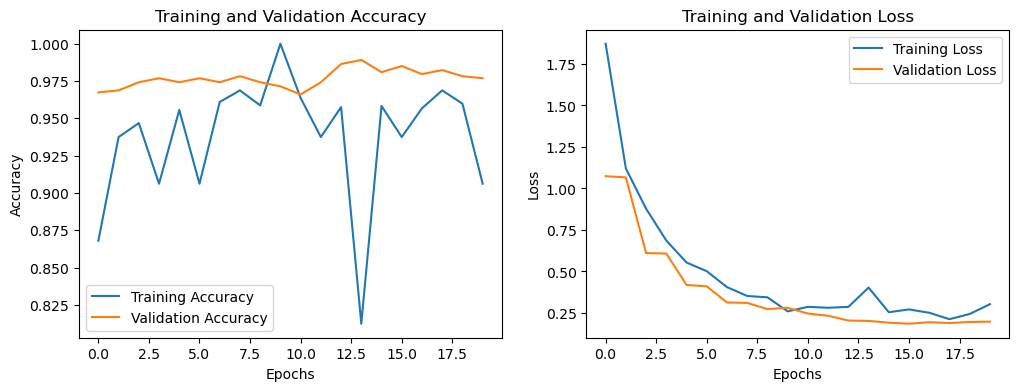

In [16]:
# Plot training & validation accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [19]:
# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f"Test accuracy: {test_acc}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 31s 3s/step - accuracy: 0.9916 - loss: 0.1798
Test accuracy: 0.9772727489471436


12/12 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step 


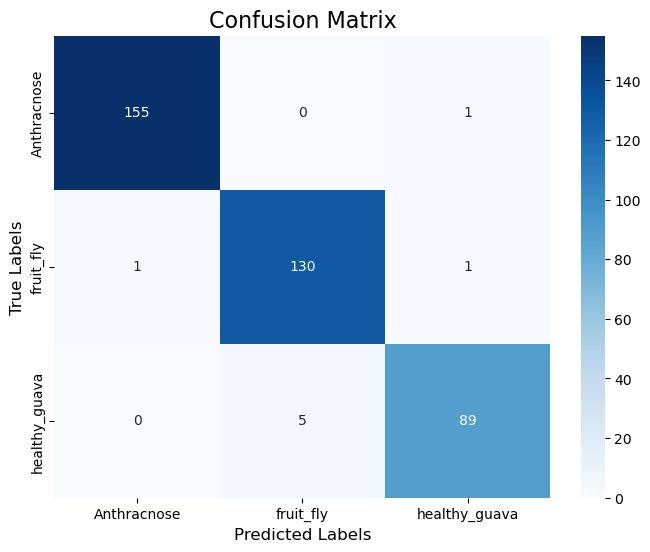

Classification Report:
Anthracnose - Precision: 0.99, Recall: 0.99, F1-Score: 0.99
fruit_fly - Precision: 0.96, Recall: 0.98, F1-Score: 0.97
healthy_guava - Precision: 0.98, Recall: 0.95, F1-Score: 0.96

Overall Metrics:
Accuracy: 0.98, Macro Avg F1-Score: 0.98, Weighted Avg F1-Score: 0.98


In [22]:
# Extract true labels
y_true = test_generator.classes

# Predict on the test data
y_pred_probs = model.predict(test_generator, steps=test_generator.samples // batch_size + 1)  # Predict probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class indices

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
labels = list(test_generator.class_indices.keys())  # Class labels

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix", fontsize=16)
plt.xlabel("Predicted Labels", fontsize=12)
plt.ylabel("True Labels", fontsize=12)
plt.show()

# Classification Report
classification_rep = classification_report(y_true, y_pred, target_names=labels, output_dict=True)

# Print the classification report
print("\033[1mClassification Report:\033[0m")
for label, metrics in classification_rep.items():
    if label in labels:
        precision = metrics['precision']
        recall = metrics['recall']
        f1 = metrics['f1-score']
        print(
            f"\033[1;34m{label}\033[0m - "
            f"\033[1;32mPrecision:\033[0m {precision:.2f}, "
            f"\033[1;33mRecall:\033[0m {recall:.2f}, "
            f"\033[1;35mF1-Score:\033[0m {f1:.2f}"
        )

# Summary metrics
print("\n\033[1;36mOverall Metrics:\033[0m")
print(
    f"\033[1;32mAccuracy:\033[0m {classification_rep['accuracy']:.2f}, "
    f"\033[1;33mMacro Avg F1-Score:\033[0m {classification_rep['macro avg']['f1-score']:.2f}, "
    f"\033[1;35mWeighted Avg F1-Score:\033[0m {classification_rep['weighted avg']['f1-score']:.2f}"
)